### Setting up

In [158]:
import math

from IPython import display
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn import metrics

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
display.display(tf.test.gpu_device_name())
pd.options.display.max_rows = 10
pd.set_option('display.float_format', lambda x: "%.1f" % x)
style.use('ggplot')

'/device:GPU:0'

### Loading data sand randomization

In [159]:
iris_dataframe = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
    sep=',', names=["sepal_length", "sepal_width", "petal_length", "petal_width", "species"])
display.display(iris_dataframe.head())

# recoding labels
iris_dataframe["species"] = iris_dataframe["species"].apply(
    lambda p: 0 if p == "Iris-setosa" else (1 if p == "Iris-versicolor" else 2))
display.display(iris_dataframe.head())

##########################################################
# other way
iris_otherway_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", 
    sep=",", names=["sepal_length", "sepal_width", "petal_length", "petal_width", "species"])

def category_conversion(df, column_name_of_df):
  return pd.to_numeric(pd.Categorical(df[column_name_of_df]).codes)

iris_otherway_df["species"] = category_conversion(iris_otherway_df, "species")
iris_otherway_df["species"] = iris_otherway_df.species.astype('int32')
display.display(iris_otherway_df.tail())

iris_otherway_df = iris_otherway_df.reindex(np.random.permutation(iris_otherway_df.index))
display.display(iris_otherway_df.head())

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


,sepal_length,sepal_width,petal_length,petal_width,species
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


,sepal_length,sepal_width,petal_length,petal_width,species
10,5.4,3.7,1.5,0.2,0
122,7.7,2.8,6.7,2.0,2
93,5.0,2.3,3.3,1.0,1
70,5.9,3.2,4.8,1.8,1
53,5.5,2.3,4.0,1.3,1


### Exploration

In [160]:
display.display(iris_otherway_df.describe())

,sepal_length,sepal_width,petal_length,petal_width,species
count,150.0,150.0,150.0,150.0,150.0
mean,5.8,3.1,3.8,1.2,1.0
std,0.8,0.4,1.8,0.8,0.8
min,4.3,2.0,1.0,0.1,0.0
25%,5.1,2.8,1.6,0.3,0.0
50%,5.8,3.0,4.3,1.3,1.0
75%,6.4,3.3,5.1,1.8,2.0
max,7.9,4.4,6.9,2.5,2.0


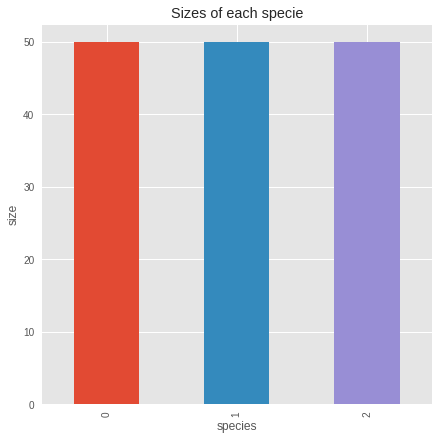

In [161]:
iris_otherway_df.groupby("species").size().plot(
    figsize=(7, 7), kind="bar", title="Sizes of each specie")
plt.ylabel("size")
plt.show()

### Preprocess data

In [0]:
def preprocess_features(my_df):
  features_ = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
  selected_features = my_df[features_]
  processed_features = selected_features.copy()
  return processed_features

def preprocess_targets(my_df):
  output_targets = pd.DataFrame()
  output_targets["species"] = my_df["species"]
  return output_targets

### Training set and Validation set

In [163]:
training_examples = preprocess_features(iris_otherway_df[0:100])
training_targets = preprocess_targets(iris_otherway_df[0:100])
display.display(training_examples.head())
display.display(training_targets.head())

validation_examples = preprocess_features(iris_otherway_df[100:150])
validation_targets = preprocess_targets(iris_otherway_df[100:150])
display.display(validation_examples.head())
display.display(validation_targets.head())

,sepal_length,sepal_width,petal_length,petal_width
10,5.4,3.7,1.5,0.2
122,7.7,2.8,6.7,2.0
93,5.0,2.3,3.3,1.0
70,5.9,3.2,4.8,1.8
53,5.5,2.3,4.0,1.3


,species
10,0
122,2
93,1
70,1
53,1


,sepal_length,sepal_width,petal_length,petal_width
79,5.7,2.6,3.5,1.0
6,4.6,3.4,1.4,0.3
80,5.5,2.4,3.8,1.1
135,7.7,3.0,6.1,2.3
140,6.7,3.1,5.6,2.4


,species
79,1
6,0
80,1
135,2
140,2


### Construct feature columns

In [0]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature) 
             for my_feature in input_features])

### Input functions

In [0]:
def my_input_fn(
    features, targets, batch_size=1, shuffle=True, num_epochs=None):
  features = {key: np.array(value) for key, value in dict(features).items()}
  ds = Dataset.from_tensor_slices((features, targets))
  ds = ds.batch(batch_size).repeat(num_epochs)
  if shuffle:
    ds = ds.shuffle(buffer_size=100)
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

### Training a model

In [0]:
def train_nn_classification_model(
    my_optimizer,
    batch_size,
    steps,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  
  periods = 10
  steps_per_period = steps / periods
  
  ### Create and configure dnn_classifier object
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  
  classifier = tf.estimator.DNNClassifier(
      feature_columns = construct_feature_columns(training_examples),
      n_classes = 3,
      hidden_units = hidden_units,
      optimizer = my_optimizer
  )
  
  ### create input_fn
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["species"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["species"], 
      shuffle=False, 
      num_epochs=1)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, 
      validation_targets["species"], 
      shuffle=False, 
      num_epochs=1)
  
  ### train the model
  print("Training the model ...")
  print("  Logloss error (on training data and validation data) : ")
  training_log_losses = []
  validation_log_losses = []
  for period in range(0, periods):
    classifier.train(
        input_fn = training_input_fn,
        steps = steps_per_period
    )
    
    ### compute probabilities
    training_predictions = list(classifier.predict(
        input_fn=predict_training_input_fn))
    training_probabilities = np.array(
        [item['probabilities'] for item in training_predictions])
    training_pred_class_id = np.array(
        [item['class_ids'][0] for item in training_predictions])
    training_pred_one_hot = tf.keras.utils.to_categorical(
        training_pred_class_id, 3)
    
    validation_predictions = list(classifier.predict(
        input_fn=predict_validation_input_fn))
    validation_probabilities = np.array(
        [item['probabilities'] for item in validation_predictions])
    validation_pred_class_id = np.array(
        [item['class_ids'][0] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(
        validation_pred_class_id, 3)
    
    ### compute training and validation errors
    training_log_loss = metrics.log_loss(
        training_targets, training_pred_one_hot)
    validation_log_loss = metrics.log_loss(
        validation_targets, validation_pred_one_hot)
    
    print("    Period {:02d} : {:.4f}\t{:.4f}".format(
        period, training_log_loss, validation_log_loss))
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  final_predictions = classifier.predict(
      input_fn=predict_validation_input_fn)
  final_predictions = np.array(
      [item['class_ids'][0] for item in final_predictions])
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("\nFinal accuracy (on validation data) : {:.4f}\n".format(accuracy))
  
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training_loss", color="magenta")
  plt.plot(validation_log_losses, label="validation_loss", color="g")
  plt.legend()
  plt.show()
  return classifier

Training the model ...
  Logloss error (on training data and validation data) : 
    Period 00 : 16.2332	12.4340
    Period 01 : 11.0524	12.4340
    Period 02 : 11.0524	12.4340
    Period 03 : 1.3816	0.6908
    Period 04 : 1.7269	1.3816
    Period 05 : 4.1447	3.4539
    Period 06 : 8.9801	10.3616
    Period 07 : 9.6709	11.0524
    Period 08 : 12.0886	5.5262
    Period 09 : 9.3255	5.5262
Model training finished.

Final accuracy (on validation data) : 0.8400



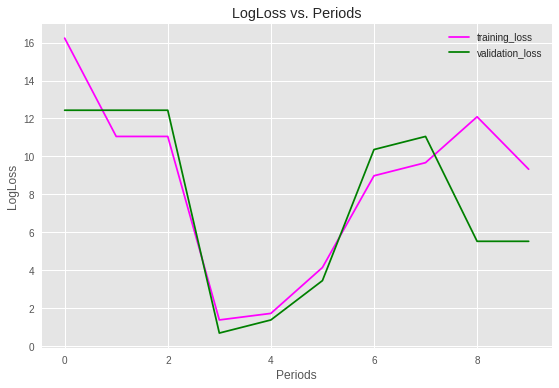

In [184]:
classifier = train_nn_classification_model(
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.025),
    batch_size = 10,
    steps = 100,
    hidden_units = [5, 10],
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
)